# Topic modelling for tweets of covid19

This notebook describes the use of _topic_modelling.py_ , a script that allows to find and visualize the main topics on a subset of our corpus of tweets about covid19. First, we go trough the steps of corpus preprocessing, then we perform un unsupervised learning in order to detect emerging topics for our study of the social narratives of the pandemic.

## Setting up

We import all the functions from the _topic_modelling.py_ script:

In [5]:
from topic_modelling import *

We import Stanza and download the processors for the language we are going to work with:

In [ ]:
import stanza
stanza.download('es', processors='tokenize,pos, lemma')

## Retrieving the data

First of all, we will use _coveet.py_ for obtaining the portion of the covid19 corpus we want to work with. 

In [6]:
GEOS = 'ar co'
LANGS = 'es'
DATES = '2020-05-08 2020-05-14'

#!python3 ../freq_analysis/coveet.py query -g $GEOS -l $LANGS -d $DATES

We save the name of the file on a variable to reuse it later to name the results of the topic modelling accordingly.

In [7]:
path = 'dhcovid_2020-5-8_2020-5-14_es_ar_co.csv'
corpus_label = path.replace('.csv', '')

Topic modelling focuses on the tweet text, so we will read the csv and keep the text information only on a variable called `tweets`. For that, we pass the name of the csv file we obtained with _coveet.py_ to the function `read_tweets_csv`:

In [8]:
tweets = read_tweets_csv(path)
tweets[:10]

['conferencia de alberto fernandez el presidente sonrie durante su mensaje pero lo cierto es que la mala situacion economica causara mas muertes que el covid19',
 'agradece a los epidemiologos porque sin ellos y con las sugerencia del ministro sanitario ademas de fundir al pais con comodidad hubiera logrado cifras peores que el topten del covid',
 'estan viendo el vivo sobre la extension de la cuarentena se dieron cuenta quien esta sentado detras del presidente si pedro cahn representante de fundacion huesped en el vivo por el covid19 ahora mismo',
 'seciones covid19 el maximo filmaker :red_heart: en',
 'en rosario tenes mas chances de morirte de cualquier cosa pero no de covid19 amo mi ciudad',
 'el sabia que eran ellos aun cuando no podia salir por la sabia que eran ellos',
 'en vivo coronavirus covid19 anuncio del presidente',
 'en la ciudad autonoma de buenos aires sigue todo igual',
 'mar del plata libre de covid',
 'fase 4 en todos el pais excepto amba que sigue en fase 3 alguien

## Preprocessing

NLP tasks as topic modelling can yield better and quicker results thanks to preprocessing. In this step, we will remove some tokens, simplify others and add grammatical information to others in order to improve the quality of the input data for the topic modelling.

First, we remove the emojilabels using `remove_emojis`:

In [9]:
tweets = [remove_emojis(tweet).strip() for tweet in tweets]
tweets = [tweet for tweet in tweets if tweet]

Now we process the tweets with Stanza (from Stanford NLP) for part of speech detection (POS) and lemmatization using `make_stanza_tweets` function. We perform the POS because we are interested in identifying nouns, since it is the category that prototypically holds the more information load of a text and we apply lemmatization because we want to reduce all the flexions of a word to the same form.

`make_stanza_tweets` needs a language code and the list of tweets.
⚠️ This function can take several hours if your corpus is too big!

In [10]:
#stanza_tweets = make_stanza_tweets('es', tweets[:20000])

2020-08-03 20:26:05 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2020-08-03 20:26:05 INFO: Use device: cpu
2020-08-03 20:26:05 INFO: Loading: tokenize
2020-08-03 20:26:05 INFO: Loading: pos
2020-08-03 20:26:06 INFO: Loading: lemma
2020-08-03 20:26:06 INFO: Done loading processors!
Tokenizing, applying POS and lemmatizing tweets: 100%|██████████| 20000/20000 [1:10:50<00:00,  4.71it/s]


Now our tweets have a lot of linguistic information added by Stanza. Let's see a tweet before and after applying Stanza:

In [11]:
tweets[7]

'en la ciudad autonoma de buenos aires sigue todo igual'

In [12]:
stanza_tweets[7]

[
  [
    {
      "id": "1",
      "text": "en",
      "lemma": "en",
      "upos": "ADP",
      "xpos": "ADP",
      "feats": "AdpType=Prep",
      "misc": "start_char=0|end_char=2"
    },
    {
      "id": "2",
      "text": "la",
      "lemma": "el",
      "upos": "DET",
      "xpos": "DET",
      "feats": "Definite=Def|Gender=Fem|Number=Sing|PronType=Art",
      "misc": "start_char=3|end_char=5"
    },
    {
      "id": "3",
      "text": "ciudad",
      "lemma": "ciudad",
      "upos": "NOUN",
      "xpos": "NOUN",
      "feats": "Gender=Fem|Number=Sing",
      "misc": "start_char=6|end_char=12"
    },
    {
      "id": "4",
      "text": "autonoma",
      "lemma": "autonomo",
      "upos": "ADJ",
      "xpos": "ADJ",
      "feats": "Gender=Fem|Number=Sing",
      "misc": "start_char=13|end_char=21"
    },
    {
      "id": "5",
      "text": "de",
      "lemma": "de",
      "upos": "ADP",
      "xpos": "ADP",
      "feats": "AdpType=Prep",
      "misc": "start_char=22|end_char=24

Let's reduce this keeping only the data we need for topic modelling. For this, we remove stopwords and numbers and for each tweet we keep two versions: a list of all the lemmas of the tweet (all POS) and a list of all the lemmatized nouns of the tweet.

First, we read our stopwords list:

In [13]:
stopwords = read_stopwords('es')

`read_stopwords` needs a language code.

Then, we build the lists of lemmas and the lists of nouns using `make_lemmas_list_nouns_list`:

In [23]:
lemmas_tweets, nouns_tweets = make_lemmas_list_nouns_list(stanza_tweets, stopwords)

Let's see the same tweet in each list:

In [24]:
print(f'Original tweet: {tweets[7]}')
print(f'Processed tweet (all lemmas): {lemmas_tweets[7]}')
print(f'Processed tweets (nouns only): {nouns_tweets[7]}')

Original tweet: en la ciudad autonoma de buenos aires sigue todo igual
Processed tweet (all lemmas): ['ciudad', 'autonomo', 'buen', 'aire', 'seguir', 'igual']
Processed tweets (nouns only): ['ciudad', 'aire']


Why do we need these two versions of the same tweet? Because we will use the nouns only version of the tweet for topic modelling but we are interested in expressions such as "nuevo caso" or "flexibilizar cuarentena" which include more than just nouns. The function `add_ngrams_to_tweets` uses the version of the tweet with all the lemmas to generate bigrams and then adds these bigrams to the corresponding noun list:

In [25]:
nouns_tweets_with_bigrams = add_ngrams_to_tweets(lemmas_tweets, nouns_tweets, verbose=False)

We can set `add_ngrams_to_tweets` to True to see the bigrams as they are added to the new list.

This was the final step of preprocessing, this is how the tweets have changed:

In [26]:
print(f'Original tweet: {tweets[15]}')
print(f'Processed tweet (all lemmas): {lemmas_tweets[15]}')
print(f'Processed tweet (nouns only): {nouns_tweets[15]}')
print(f'Processed tweet (nouns only) + bigram: {nouns_tweets_with_bigrams[15]}')

Original tweet: covid19 no hay nuevos casos en santa fe y en argentina la cifra de muertos alcanzo los
Processed tweet (all lemmas): ['covid19', 'nuevo', 'caso', 'santo', 'fe', 'argentino', 'cifra', 'muerto', 'alcanzar']
Processed tweet (nouns only): ['caso', 'fe', 'argentino', 'cifra', 'muerto', 'nuevo_caso', 'santo_fe']
Processed tweet (nouns only) + bigram: ['caso', 'fe', 'argentino', 'cifra', 'muerto', 'nuevo_caso', 'santo_fe']


## Unsupervised learning

We can now proceed to the proper topic modelling. We will train our model with LDA algorithm on a corpus of lemmatized tweets with bigrams, so we create a label for naming the model files with that information. These files will be saved in the `models_dir` folder that will be created by _topic_modelling.py_ :

In [27]:
model_label = 'lemma_2gram_LDA'
models_dir = "../../outputs/topic_modelling/gensim_LDA_models"

Now we call `train_several_LDA_models` in order to generate the topics of our corpus of tweets. In `tweets` parameter we must define the training corpus. We don't know in advance how many interesting topics can emerge from the corpus, so we set a range of topic numbers to modelize in `topic_numbers_to_try`. The value of `corpus_label` will be used with `model_label` to name the output files.

⚠️ Training can take several hours when executing for the first time!

In [28]:
models = train_several_LDA_models(
    tweets=nouns_tweets_with_bigrams,
    topic_numbers_to_try=range(3, 8),
    corpus_label=corpus_label,
    model_label=model_label,
    models_dir=models_dir
)

Training LDA model with 3 topics
Saving in ../../outputs/topic_modelling/gensim_LDA_models/dhcovid_2020-5-8_2020-5-14_es_ar_co-lemma_2gram_LDA-ntopics03
Training LDA model with 4 topics
Saving in ../../outputs/topic_modelling/gensim_LDA_models/dhcovid_2020-5-8_2020-5-14_es_ar_co-lemma_2gram_LDA-ntopics04
Training LDA model with 5 topics
Saving in ../../outputs/topic_modelling/gensim_LDA_models/dhcovid_2020-5-8_2020-5-14_es_ar_co-lemma_2gram_LDA-ntopics05
Training LDA model with 6 topics
Saving in ../../outputs/topic_modelling/gensim_LDA_models/dhcovid_2020-5-8_2020-5-14_es_ar_co-lemma_2gram_LDA-ntopics06
Training LDA model with 7 topics
Saving in ../../outputs/topic_modelling/gensim_LDA_models/dhcovid_2020-5-8_2020-5-14_es_ar_co-lemma_2gram_LDA-ntopics07


## Calculating topic coherence

In the previous step, we have trained different models for a range of topics, since we can't know in advance how many topics are in the corpus. How can we choose the model with the number of topics that best represents the actual topics of the corpus? Topic coherence is a measure that evaluates each topic in the different models and allows us to find the best number of topics automatically.

⚠️ `calculate_topic_coherence` must receive the same corpus as `train_several_LDA_models`!

In [29]:
scores = calculate_topic_coherence(models, nouns_tweets_with_bigrams)

Calculating model coherence: 100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


Let's visualize the topic coherence in a graphic:

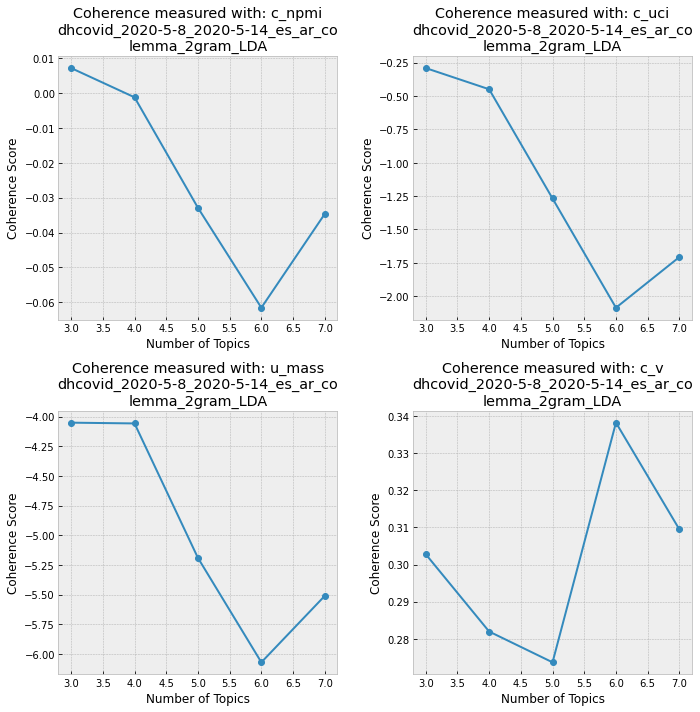

In [30]:
plot_scores(corpus_label, model_label, models_dir, scores)

Now that we know which are the best models, we can visualize the topics of those models.

## Visualizing the models

On this step, we use pyLDAvis to visualize the models that obtained the best scores for topic coherence. We use `plot_LDA_topics` with the number of topics that received the best scores:

In [31]:
plot_LDA_topics(models[3], nouns_tweets_with_bigrams)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.091221 -0.224234       1        1  42.859150
2     -0.247466  0.036116       2        1  29.974047
1      0.156245  0.188117       3        1  27.166801, topic_info=           Term         Freq        Total Category  logprob  loglift
53         caso  3045.000000  3045.000000  Default  30.0000  30.0000
121    contagio   860.000000   860.000000  Default  29.0000  29.0000
71     paciente   643.000000   643.000000  Default  28.0000  28.0000
4        muerte   639.000000   639.000000  Default  27.0000  27.0000
213         año   551.000000   551.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
227        vida   162.586716   318.861481   Topic3  -5.4438   0.6296
17   cuarentena   181.310669   530.899414   Topic3  -5.3348   0.2288
80          mes   137.794235   256.278229   Topic3  -5.6092   0.6827
283      semana   125.082199   266.544708   Topic3  -5.7060   0.5466
91          dia   127.477333  1134.494995   Topic3  -5.6870  -0.8828

[170 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
422       1  0.996165       acción
906       1  0.996834    actividad
37        2  0.998301         aire
92        1  0.214273  aislamiento
92        2  0.783712  aislamiento
...     ...       ...          ...
370       1  0.378005        virus
370       2  0.158907        virus
370       3  0.462274        virus
243       2  0.086621            x
243       3  0.912850            x

[183 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [32]:
plot_LDA_topics(models[4], nouns_tweets_with_bigrams)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.189631 -0.024689       1        1  27.439054
2      0.190411 -0.196514       2        1  24.237862
1     -0.163356  0.009897       3        1  24.218632
0      0.162575  0.211306       4        1  24.104456, topic_info=            Term         Freq        Total Category  logprob  loglift
53          caso  3015.000000  3015.000000  Default  30.0000  30.0000
124        salud  1081.000000  1081.000000  Default  29.0000  29.0000
4         muerte   641.000000   641.000000  Default  28.0000  28.0000
476   emergencia   451.000000   451.000000  Default  27.0000  27.0000
12          pais   829.000000   829.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
60        medida   259.841858   665.091431   Topic4  -4.8553   0.4829
763       millón   154.780991   307.259277   Topic4  -5.3734   0.7371
659        medio   146.104782   260.760376   Topic4  -5.4310   0.8435
587  informacion   156.148010   333.018585   Topic4  -5.3646   0.6654
102         mayo   139.941986   675.500122   Topic4  -5.4741  -0.1515

[233 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
422       2  0.820837     acción
422       4  0.177226     acción
906       4  0.997990  actividad
896       1  0.988718       agua
37        1  0.995284       aire
...     ...       ...        ...
370       1  0.452563      virus
370       2  0.173879      virus
370       3  0.223899      virus
370       4  0.150060      virus
243       3  0.995082          x

[273 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

We can save the graphics to reuse them outside this notebook using the same `plot_LDA_topics` function and passing a path to `output_path` parameter:

In [33]:
plot_path = make_model_path(models_dir, corpus_label, model_label, 3) + ".html"
plot_LDA_topics(models[3], nouns_tweets_with_bigrams, output_path=plot_path, show=False)

Saving topic visualization to: ../../outputs/topic_modelling/gensim_LDA_models/dhcovid_2020-5-8_2020-5-14_es_ar_co-lemma_2gram_LDA-ntopics03.html


In [34]:
plot_path = make_model_path(models_dir, corpus_label, model_label, 4) + ".html"
plot_LDA_topics(models[5], nouns_tweets_with_bigrams, output_path=plot_path, show=False)

Saving topic visualization to: ../../outputs/topic_modelling/gensim_LDA_models/dhcovid_2020-5-8_2020-5-14_es_ar_co-lemma_2gram_LDA-ntopics04.html
